# Load packages

In [203]:
# Packages
import os
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from nervaluate import Evaluator
import itertools
from IPython.display import display
from utils import preprocess_rater, list_overlap, average_score, rater_avg_df

# Load data and preprocess

In [204]:
def prepare_NER(df_rater):
    """Function to prepare NER tags for a single rater for interrater calculations.

    Args:
        df_rater (pd.DataFrame): preprocessed dataframe of single rater

    Returns:
        pd.DataFrame: dataframe with preprocessed NER tags, one row per token, with NER tags
    """
    irrelevant_columns = [
        i
        for i in [
            "meta",
            "_input_hash",
            "_task_hash",
            "_is_binary",
            "_view_id",
            "answer",
            "_timestamp",
        ]
        if i in df_rater.columns
    ]
    df_clean = df_rater.drop(irrelevant_columns, axis=1)#.drop(["meta", "_input_hash", "_task_hash", "_is_binary", "_view_id", "answer", "_timestamp"], axis=1)
    # Put each token on its own line
    exploded_tokens = df_clean.explode("tokens", ignore_index=True)
    # Normalise tokens column (expanding json format)
    normalised_tokens = pd.json_normalize(exploded_tokens["tokens"]).add_prefix("tokens_")
    # Add normalised columns to the data and delete old spans
    tokens = pd.concat([exploded_tokens, normalised_tokens], axis=1)

    # Put each rated NE on its own line
    exploded_spans = tokens.explode("spans", ignore_index=True)
    # Normalise span column
    normalised_spans = pd.json_normalize(exploded_spans["spans"]).add_prefix("spans_")
    # Normalise spans so that the info is in the dataframe
    spans = pd.concat([exploded_spans, normalised_spans], axis=1)

    # Only keep one row for each NE, i.e. only keep the rows where the token is within in the span of the NE 
    ne_tokens = spans[(spans.tokens_id >= spans.spans_token_start) & (spans.tokens_id <= spans.spans_token_end)]
    #print("Number of NEs for rater:", ne_tokens.shape)
    ne_tokens = ne_tokens.drop(["spans", "tokens"], axis=1)

    return pd.merge(tokens, ne_tokens, on=['rater_id', 'doc', 'tokens_text', 'tokens_start', 'tokens_end', 'tokens_id', 'tokens_ws'], how="outer") 

In [205]:
raterdf_list = []
NERdf_list = []

for id in range(1, 11):
    if not id == 2 and not id == 10:
        raw_data = pd.read_json(f"../../../data/prodigy_exports/prodigy{id}_db_exports/NER_merged_annotator{id}.jsonl", lines=True)

        # List of preprocessed data
        preprocessed_df = preprocess_rater(raw_data, id)
        raterdf_list.append(preprocessed_df)

        # List of NER data
        NER_df = prepare_NER(preprocessed_df)
        NERdf_list.append(NER_df)

model_raw = pd.read_json("../../../data/full/gold/gold.jsonl", lines=True)
model_preprocessed = preprocess_rater(model_raw, "gold")
raterdf_list.append(model_preprocessed)
model_NER = prepare_NER(model_preprocessed)
NERdf_list.append(model_NER)

In [206]:
NERdf_list[8].head()

,rater_id,doc,tokens,spans,_session_id_x,sessions_x,versions_x,view_id_x,tokens_text,tokens_start,...,tokens_ws,_session_id_y,sessions_y,versions_y,view_id_y,spans_start,spans_end,spans_label,spans_token_start,spans_token_end
0,gold,"Det fremgår af sagens oplysninger, at klageren...","{'text': 'Det', 'start': 0, 'end': 3, 'id': 0,...",[],gold-bad,"[gold-bad, gold-bad-no-tags]","[{'text': 'Det fremgår af sagens oplysninger, ...",ner_manual,Det,0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,gold,"Det fremgår af sagens oplysninger, at klageren...","{'text': 'fremgår', 'start': 4, 'end': 11, 'id...",[],gold-bad,"[gold-bad, gold-bad-no-tags]","[{'text': 'Det fremgår af sagens oplysninger, ...",ner_manual,fremgår,4,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gold,"Det fremgår af sagens oplysninger, at klageren...","{'text': 'af', 'start': 12, 'end': 14, 'id': 2...",[],gold-bad,"[gold-bad, gold-bad-no-tags]","[{'text': 'Det fremgår af sagens oplysninger, ...",ner_manual,af,12,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,gold,"Det fremgår af sagens oplysninger, at klageren...","{'text': 'sagens', 'start': 15, 'end': 21, 'id...",[],gold-bad,"[gold-bad, gold-bad-no-tags]","[{'text': 'Det fremgår af sagens oplysninger, ...",ner_manual,sagens,15,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gold,"Det fremgår af sagens oplysninger, at klageren...","{'text': 'oplysninger', 'start': 22, 'end': 33...",[],gold-bad,"[gold-bad, gold-bad-no-tags]","[{'text': 'Det fremgår af sagens oplysninger, ...",ner_manual,oplysninger,22,...,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### After loading data, we now have the following format, in which:
- Each element is a dataframe
- raterdf_list has entire doc in each row, with a list of tokens in each
    - spans, have information on where token is located and any NER-tag
- NERdf_list has single tokens in each row
    - spans_label, has information on any potential token-tag

In [207]:
print(raterdf_list[0]["doc"][0])
print(raterdf_list[0]["spans"][0])
print(raterdf_list[0]["spans"][0][0]["label"])
raterdf_list[0].head(2)

Hvordan kan statsministeren kalde børn,der er født på danske hospitaler for indvandrerdrenge!
[{'start': 54, 'end': 60, 'token_start': 10, 'token_end': 10, 'label': 'NORP'}]
NORP


,rater_id,doc,meta,_input_hash,_task_hash,tokens,spans,_is_binary,_view_id,answer,_timestamp,duplicate
0,1,"Hvordan kan statsministeren kalde børn,der er ...","{'start_id': '1296181799450804226', 'start_use...",-1711421309,1126198221,"[{'text': 'Hvordan', 'start': 0, 'end': 7, 'id...","[{'start': 54, 'end': 60, 'token_start': 10, '...",False,ner_manual,accept,1635260113,False
1,1,Det her er jo håbløst #dkpol https://t.co/e7h...,"{'start_id': '1296181799450804226', 'start_use...",-1460346606,-849706175,"[{'text': 'Det', 'start': 0, 'end': 3, 'id': 0...",[],False,ner_manual,accept,1635322021,False


In [208]:
print(NERdf_list[0]["spans_label"][6])
print(NERdf_list[0]["spans"][6])

NERdf_list[0].head(2)

nan
[{'start': 54, 'end': 60, 'token_start': 10, 'token_end': 10, 'label': 'NORP'}]


,rater_id,doc,tokens,spans,duplicate_x,tokens_text,tokens_start,tokens_end,tokens_id,tokens_ws,duplicate_y,spans_start,spans_end,spans_token_start,spans_token_end,spans_label
0,1,"Hvordan kan statsministeren kalde børn,der er ...","{'text': 'Hvordan', 'start': 0, 'end': 7, 'id'...","[{'start': 54, 'end': 60, 'token_start': 10, '...",False,Hvordan,0,7,0,True,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"Hvordan kan statsministeren kalde børn,der er ...","{'text': 'kan', 'start': 8, 'end': 11, 'id': 1...","[{'start': 54, 'end': 60, 'token_start': 10, '...",False,kan,8,11,1,True,NaN,NaN,NaN,NaN,NaN,NaN


# Explore interrater reliability

### How do the documents overlap between raters?

In [209]:
# Get rater ids
raters = [df.rater_id[1] for df in raterdf_list]
print(raters)

[1, 3, 4, 5, 6, 7, 8, 9, 'gold']


In [210]:
# Check document overlap of annotators
overlap_list = []
for i in range(len(raters)):
    raterA_df = raterdf_list[i]
    overlap_list.append([len(list_overlap(raterA_df.doc, raterB_df.doc)) for raterB_df in raterdf_list])

# Create dataframe for text overlap
print("OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS")
overlap_df = pd.DataFrame(data=np.array(overlap_list), index=raters, columns=pd.Index(raters, name="Rater"))
overlap_df

#overlap_df.to_csv("../../output/NER/NER_doc_overlap.csv")

OVERLAP OF UNIQUE DOCUMENTS FOR RATERS ON NER TAGS


Rater,1,3,4,5,6,7,8,9,gold
1,1995,586,530,595,605,575,534,581,1952
3,586,2043,544,587,600,575,530,576,1969
4,530,544,2817,531,543,514,470,523,2723
5,595,587,531,1947,600,584,533,580,1919
6,605,600,543,600,2722,583,544,592,2603
7,575,575,514,584,583,2312,521,573,2235
8,534,530,470,533,544,521,2241,567,2179
9,581,576,523,580,592,573,567,2635,2520
gold,1952,1969,2723,1919,2603,2235,2179,2520,13957


### How much do the raters agree with one another on the NER tagging (including cases in which neither tagged a given word)

In [211]:
kappa_list = []
token_overlap_list = []

# For each rater
for raterA in range(len(raters)):
    
    kappa_rater = []
    token_overlap_rater = []

    # Create pair with another rater
    for raterB in range(len(raters)):

        # Merge dataframes on tokens
        df_pair = pd.merge(NERdf_list[raterA], NERdf_list[raterB], on=["doc", "tokens_text", "tokens_start", "tokens_end"], suffixes=["_raterA", "_raterB"])
        df_pair[["spans_label_raterA", "spans_label_raterB"]] = df_pair[["spans_label_raterA", "spans_label_raterB"]].fillna("")
        
        # Get the number of overlapping tokens
        token_overlap = len(df_pair)
        token_overlap_rater.append(token_overlap)
        # Get kappa
        kappa = cohen_kappa_score(df_pair.spans_label_raterA, df_pair.spans_label_raterB)
        kappa_rater.append(kappa)

    kappa_list.append(kappa_rater)
    token_overlap_list.append(token_overlap_rater)

kappa_array = np.array(kappa_list)
token_overlap_array = np.array(token_overlap_list)

In [212]:
kappa_df = pd.DataFrame(data=kappa_array, index=raters, columns=pd.Index(raters, name="Rater"))

# Print average kappa across pairs
print("AVERAGE KAPPA ACROSS PAIRS")
average_score(kappa_df)

# Print df with pairwise scores
print("\nPAIRWISE KAPPAS")
kappa_df_avg = rater_avg_df(kappa_df).round(2)
kappa_df_avg

#kappa_df_avg.to_csv("../../output/NER/NER_kappa_all.csv")

AVERAGE KAPPA ACROSS PAIRS
Mean (SD) Score: 0.7378347048418173 (0.0792023202734452)

PAIRWISE KAPPAS


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.71,0.85,0.82,0.86,0.68,0.63,0.74,0.85,0.77
3,0.71,1.00,0.72,0.70,0.70,0.74,0.66,0.75,0.85,0.73
4,0.85,0.72,1.00,0.78,0.82,0.67,0.61,0.76,0.79,0.75
5,0.82,0.70,0.78,1.00,0.82,0.66,0.61,0.71,0.83,0.74
6,0.86,0.70,0.82,0.82,1.00,0.67,0.61,0.73,0.80,0.75
7,0.68,0.74,0.67,0.66,0.67,1.00,0.62,0.78,0.81,0.70
8,0.63,0.66,0.61,0.61,0.61,0.62,1.00,0.64,0.78,0.64
9,0.74,0.75,0.76,0.71,0.73,0.78,0.64,1.00,0.82,0.74
gold,0.85,0.85,0.79,0.83,0.80,0.81,0.78,0.82,1.00,0.82


### How much do the raters agree with one another on the NER-tagging (excluding cases in which neither tagged a given word as a NE )

In [213]:
print("PAIRWISE TOKEN OVERLAP (USED FOR CALCULATION OF KAPPAS)")
token_overlap_df = pd.DataFrame(data=token_overlap_array, index=raters, columns=pd.Index(raters, name="Rater"))
token_overlap_df

#token_overlap_df.to_csv("../../output/NER/NER_token_overlap_all.csv")

PAIRWISE TOKEN OVERLAP (USED FOR CALCULATION OF KAPPAS)


Rater,1,3,4,5,6,7,8,9,gold
1,22598,5854,5327,5877,5902,5787,5670,5740,21809
3,5854,20926,5401,5852,5914,5812,5705,5756,19971
4,5327,5401,27855,5373,5378,5272,5176,5305,26907
5,5877,5852,5373,19382,5883,5837,5671,5734,19162
6,5902,5914,5378,5883,29290,5837,5729,5800,27230
7,5787,5812,5272,5837,5837,26475,5635,5748,25509
8,5670,5705,5176,5671,5729,5635,25842,5834,25015
9,5740,5756,5305,5734,5800,5748,5834,26634,25345
gold,21809,19971,26907,19162,27230,25509,25015,25345,150878


In [214]:
kappa_list = []
token_overlap_list = []

# For each rater
for raterA in range(0, len(raters)):
    
    kappa_rater = []
    token_overlap_rater = []

    # Create pair with other raters
    for raterB in range(0, len(raters)):

        # Merge data of pairs on tokens
        df_pair = pd.merge(NERdf_list[raterA], NERdf_list[raterB], on=["doc", "tokens_text", "tokens_start", "tokens_end"], suffixes=["_raterA", "_raterB"])
        # Keep only if annotated by at least one rater
        df_annotated = df_pair.dropna(subset=["spans_label_raterA", "spans_label_raterB"], how="all").reset_index().fillna("")

        # Get number of overlapping tokens
        token_overlap = len(df_annotated)
        token_overlap_rater.append(token_overlap)
        # Get kappa
        kappa = cohen_kappa_score(df_annotated.spans_label_raterA, df_annotated.spans_label_raterB)
        kappa_rater.append(kappa)

    # Append to list
    kappa_list.append(kappa_rater)
    token_overlap_list.append(token_overlap_rater)

kappa_array = np.array(kappa_list)
token_overlap_array = np.array(token_overlap_list)

In [215]:
kappa_df = pd.DataFrame(data=kappa_array, index=raters, columns=pd.Index(raters, name="Rater"))

print("AVERAGE KAPPA ACROSS PAIRS")
average_score(kappa_df)
print("\nPAIRWISE KAPPAS")
kappa_df_avg = rater_avg_df(kappa_df).round(2)
kappa_df_avg

#kappa_df_avg.to_csv("../../output/NER/NER_kappa_annotated.csv")

AVERAGE KAPPA ACROSS PAIRS
Mean (SD) Score: 0.5394286656281957 (0.1172051629417999)

PAIRWISE KAPPAS


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.51,0.71,0.65,0.73,0.47,0.37,0.55,0.73,0.59
3,0.51,1.00,0.51,0.48,0.48,0.52,0.42,0.54,0.71,0.52
4,0.71,0.51,1.00,0.58,0.65,0.45,0.36,0.57,0.63,0.56
5,0.65,0.48,0.58,1.00,0.64,0.43,0.35,0.49,0.67,0.54
6,0.73,0.48,0.65,0.64,1.00,0.45,0.35,0.52,0.63,0.56
7,0.47,0.52,0.45,0.43,0.45,1.00,0.36,0.58,0.66,0.49
8,0.37,0.42,0.36,0.35,0.35,0.36,1.00,0.39,0.60,0.40
9,0.55,0.54,0.57,0.49,0.52,0.58,0.39,1.00,0.67,0.54
gold,0.73,0.71,0.63,0.67,0.63,0.66,0.60,0.67,1.00,0.66


### Between raters, how similar did they tag overall?

- For information on the calculations, see: https://pypi.org/project/nervaluate/


In [216]:
f1_list = []
f1_tags_list = []

# For each rater
for raterA in range(0, len(raters)):
    
    f1_rater = []
    f1_tags_rater = []

    # Pair with other rater
    for raterB in range(0, len(raters)):

        # Prepare data
        raterA_data = NERdf_list[raterA].copy().drop_duplicates(subset="doc")
        raterB_data = NERdf_list[raterB].copy().drop_duplicates(subset="doc")
        pair = pd.merge(raterA_data, raterB_data, on="doc", suffixes=["_raterA", "_raterB"], how="inner")

        # Prepare labels
        raterA_labels = pair.spans_raterA.tolist()
        raterB_labels = pair.spans_raterB.tolist()
        all_labels = list(itertools.chain.from_iterable(raterA_labels + raterB_labels))
        label_set = list(set([d["label"] for d in all_labels if "label" in d]))

        # Get F1 scores
        evaluator = Evaluator(raterA_labels, raterB_labels, tags=label_set)
        results, results_by_tag = evaluator.evaluate()

        # Append to list
        f1_rater.append(results)
        f1_tags_rater.append(results_by_tag)

    f1_list.append(f1_rater)
    f1_tags_list.append(f1_tags_rater)

In [217]:
# Extract separate f1 scores from results and store in arrays in dict
f1_dict = {
    "STRICT": np.array([[f1B["strict"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "EXACT": np.array([[f1B["exact"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "PARTIAL": np.array([[f1B["partial"]["f1"] for f1B in f1A] for f1A in f1_list]),
    "ENT_TYPE": np.array([[f1B["ent_type"]["f1"] for f1B in f1A] for f1A in f1_list])
}

# Print results for each type of F1 Score
for type in f1_dict.keys():

    type_df = pd.DataFrame(data=f1_dict[type], index=raters, columns=pd.Index(raters, name="Rater"))

    print(f"AVERAGE F1 SCORE ON {type} MATCH")
    average_score(type_df)

    print(f"\nPAIRWISE F1 SCORE ON {type} MATCH")
    type_df_avg = rater_avg_df(type_df).round(2)
    display(type_df_avg)

    #type_df_avg.to_csv(f"../../output/NER/NER_F1_{type}.csv")

AVERAGE F1 SCORE ON STRICT MATCH
Mean (SD) Score: 0.6441861395726595 (0.0895610019146711)

PAIRWISE F1 SCORE ON STRICT MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.71,0.75,0.73,0.75,0.65,0.53,0.71,0.79,0.70
3,0.71,1.00,0.67,0.61,0.65,0.68,0.56,0.68,0.75,0.66
4,0.75,0.67,1.00,0.64,0.65,0.58,0.53,0.71,0.68,0.65
5,0.73,0.61,0.64,1.00,0.67,0.65,0.48,0.64,0.78,0.65
6,0.75,0.65,0.65,0.67,1.00,0.57,0.47,0.60,0.51,0.61
7,0.65,0.68,0.58,0.65,0.57,1.00,0.47,0.67,0.77,0.63
8,0.53,0.56,0.53,0.48,0.47,0.47,1.00,0.54,0.68,0.53
9,0.71,0.68,0.71,0.64,0.60,0.67,0.54,1.00,0.68,0.65
gold,0.79,0.75,0.68,0.78,0.51,0.77,0.68,0.68,1.00,0.71


AVERAGE F1 SCORE ON EXACT MATCH
Mean (SD) Score: 0.7413849166901456 (0.07832168436414919)

PAIRWISE F1 SCORE ON EXACT MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.76,0.86,0.84,0.79,0.76,0.64,0.78,0.83,0.78
3,0.76,1.00,0.76,0.75,0.71,0.78,0.67,0.79,0.78,0.75
4,0.86,0.76,1.00,0.79,0.77,0.78,0.65,0.80,0.77,0.77
5,0.84,0.75,0.79,1.00,0.78,0.73,0.62,0.74,0.82,0.76
6,0.79,0.71,0.77,0.78,1.00,0.66,0.57,0.67,0.59,0.69
7,0.76,0.78,0.78,0.73,0.66,1.00,0.62,0.82,0.88,0.75
8,0.64,0.67,0.65,0.62,0.57,0.62,1.00,0.62,0.77,0.65
9,0.78,0.79,0.80,0.74,0.67,0.82,0.62,1.00,0.73,0.74
gold,0.83,0.78,0.77,0.82,0.59,0.88,0.77,0.73,1.00,0.77


AVERAGE F1 SCORE ON PARTIAL MATCH
Mean (SD) Score: 0.7917041803126604 (0.06720307752292673)

PAIRWISE F1 SCORE ON PARTIAL MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.80,0.88,0.88,0.84,0.78,0.69,0.81,0.86,0.82
3,0.80,1.00,0.81,0.80,0.77,0.82,0.72,0.83,0.83,0.80
4,0.88,0.81,1.00,0.85,0.83,0.81,0.70,0.82,0.82,0.82
5,0.88,0.80,0.85,1.00,0.85,0.78,0.69,0.79,0.87,0.81
6,0.84,0.77,0.83,0.85,1.00,0.74,0.65,0.75,0.68,0.76
7,0.78,0.82,0.81,0.78,0.74,1.00,0.68,0.85,0.90,0.80
8,0.69,0.72,0.70,0.69,0.65,0.68,1.00,0.68,0.82,0.70
9,0.81,0.83,0.82,0.79,0.75,0.85,0.68,1.00,0.82,0.79
gold,0.86,0.83,0.82,0.87,0.68,0.90,0.82,0.82,1.00,0.83


AVERAGE F1 SCORE ON ENT_TYPE MATCH
Mean (SD) Score: 0.6968796708233792 (0.07936285979560323)

PAIRWISE F1 SCORE ON ENT_TYPE MATCH


Rater,1,3,4,5,6,7,8,9,gold,rater_avg
1,1.00,0.75,0.79,0.76,0.82,0.67,0.59,0.74,0.82,0.74
3,0.75,1.00,0.72,0.66,0.70,0.72,0.61,0.72,0.83,0.71
4,0.79,0.72,1.00,0.71,0.73,0.61,0.58,0.75,0.73,0.70
5,0.76,0.66,0.71,1.00,0.74,0.68,0.56,0.70,0.82,0.70
6,0.82,0.70,0.73,0.74,1.00,0.64,0.55,0.68,0.65,0.69
7,0.67,0.72,0.61,0.68,0.64,1.00,0.53,0.69,0.79,0.67
8,0.59,0.61,0.58,0.56,0.55,0.53,1.00,0.60,0.73,0.59
9,0.74,0.72,0.75,0.70,0.68,0.69,0.60,1.00,0.72,0.70
gold,0.82,0.83,0.73,0.82,0.65,0.79,0.73,0.72,1.00,0.76


### Between raters, how similar did they tag for each of the individual NER groups?

- For information on the calculations, see: https://pypi.org/project/nervaluate/


In [218]:
# Get unique tags across raters
tags = []
for rater in NERdf_list:
    tags = tags + rater["spans_label"].to_list()
unique_tags = list(set(tags))

In [219]:
# Get number of annotations by tag by rater
rater_tag_counts = {}

# For each rater count the number of tags
for rater in range(len(raters)):
    tag_counts = NERdf_list[rater].value_counts("spans_label")
    rater_tag_counts[NERdf_list[rater]["rater_id"][0]] = tag_counts

print("TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER")
NER_tag_counts = pd.DataFrame(rater_tag_counts).fillna(0).astype(int)
display(NER_tag_counts)

#NER_tag_counts.to_csv("../../output/NER/NER_tag_counts.csv")

TOTAL NUMBER OF ANNOTATED NER TAGS BY RATER


,1,3,4,5,6,7,8,9,gold
spans_label,,,,,,,,,
CARDINAL,327,512,230,191,422,364,338,190,2037
DATE,518,446,483,452,471,229,350,353,2937
EVENT,51,116,87,23,50,52,92,28,349
FACILITY,46,8,36,71,24,176,54,31,410
GPE,122,186,307,125,343,615,344,329,1708
LANGUAGE,4,7,27,0,1,0,5,0,133
LAW,96,29,160,23,63,126,28,198,678
LOCATION,45,34,107,23,8,230,70,74,583
MONEY,101,38,141,99,114,102,207,844,1331


In [220]:
def extract_tag_f1(f1_type, tag, results_tags_list):
    """Function to extract type of F1 score for specific tag.

    Args:
        f1_type (str): "strict", "exact", "type" or "partial"
        tag (str): NER tag
        results_tags_list (list): list of all results

    Returns:
        list: List of list of scores for each rater
    """
    scores = []
    # For each rater
    for raterA in results_tags_list:
        raterA_scores = []
        # And each pair rater 
        for raterB in raterA:
            # Get the F1 score
            if tag in raterB.keys():
                tag_scores = raterB[str(tag)][f1_type]["f1"]
            else:
                tag_scores = np.nan
                # Append to rater scores
            raterA_scores.append(tag_scores)
        # Append to all scores
        scores.append(raterA_scores)
        
    return scores

In [221]:
# Get strict F1 scores by tag
tag_f1_dict = {}
tag_avg_dict = {}

# For each tag get the strict f1 score from the results
for tag in unique_tags:
    tag_f1 = extract_tag_f1("strict", tag, f1_tags_list)
    # Pairwise f1 scores for tag
    tag_f1_dict[tag] = pd.DataFrame(tag_f1).round(2)
    # Averaged f1 scores for tag
    tag_avg_dict[tag] = average_score(pd.DataFrame(tag_f1), print_score=False)

print("AVERAGE STRICT F1-SCORE BY TAG")
tag_f1_avg = pd.DataFrame(tag_avg_dict, index=["mean", "sd"]).T.round(2).sort_index()
display(tag_f1_avg)

#tag_f1_avg.to_csv("../../output/NER/NER_F1TAG_STRICT.csv")

AVERAGE STRICT F1-SCORE BY TAG


,mean,sd
CARDINAL,0.49,0.24
DATE,0.60,0.14
EVENT,0.69,0.16
FACILITY,0.42,0.36
GPE,0.85,0.08
LANGUAGE,0.23,0.39
LAW,0.30,0.31
LOCATION,0.30,0.22
MONEY,0.96,0.11
NORP,0.62,0.22


AVERAGE STRICT F1-SCORE BY TAG AND RATER


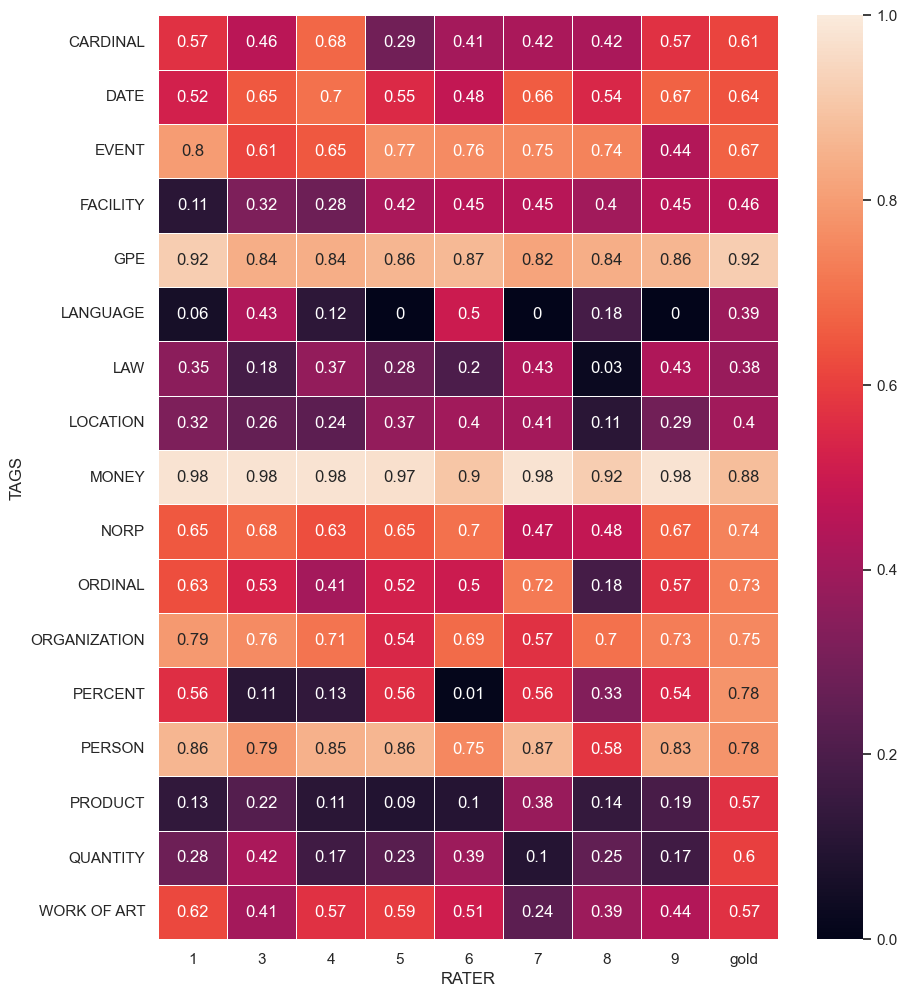

In [222]:
# Get F1 Scores by tag and rater
rater_avgs = []
# For all tags (exc)
for tag in unique_tags[1:]:
    # Extract f1 scores for tag
    tag_f1 = tag_f1_dict[tag]
    # Get the rater averages
    rater_avgs.append(rater_avg_df(tag_f1)["rater_avg"].tolist()) 

# Store in dataframe and sort
df = pd.DataFrame(rater_avgs, index = unique_tags[1:])

# drop "nan" row
for i, index in enumerate(df.index):
    if i == 6:
        df = df.drop(index)

# Sort by index name
df = df.sort_index()

# Create matrix
print("AVERAGE STRICT F1-SCORE BY TAG AND RATER")
plt.figure(figsize=(10,12))
with sns.axes_style("white"):
    s = sns.heatmap(np.array(df), xticklabels=[1,3,4,5,6,7,8,9,"gold"], yticklabels=df.index, annot=True, linewidths=0.5, vmax=1.0, cbar=True)
    s.set(ylabel='TAGS', xlabel='RATER');

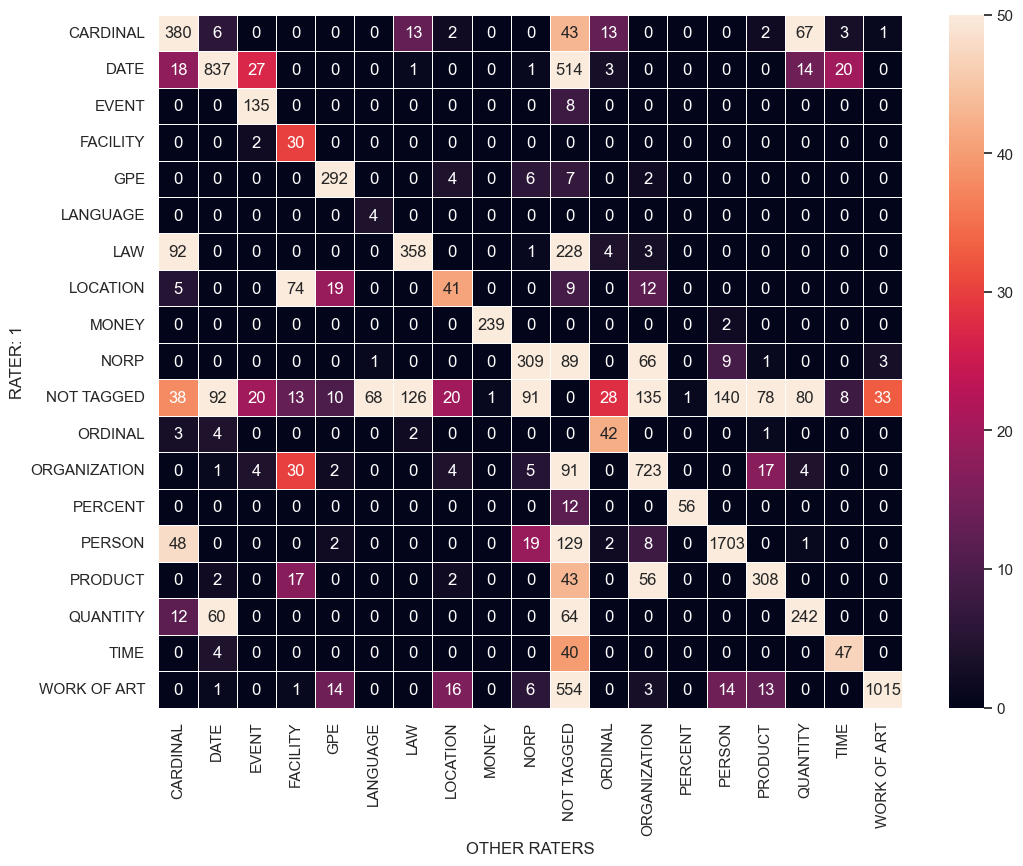

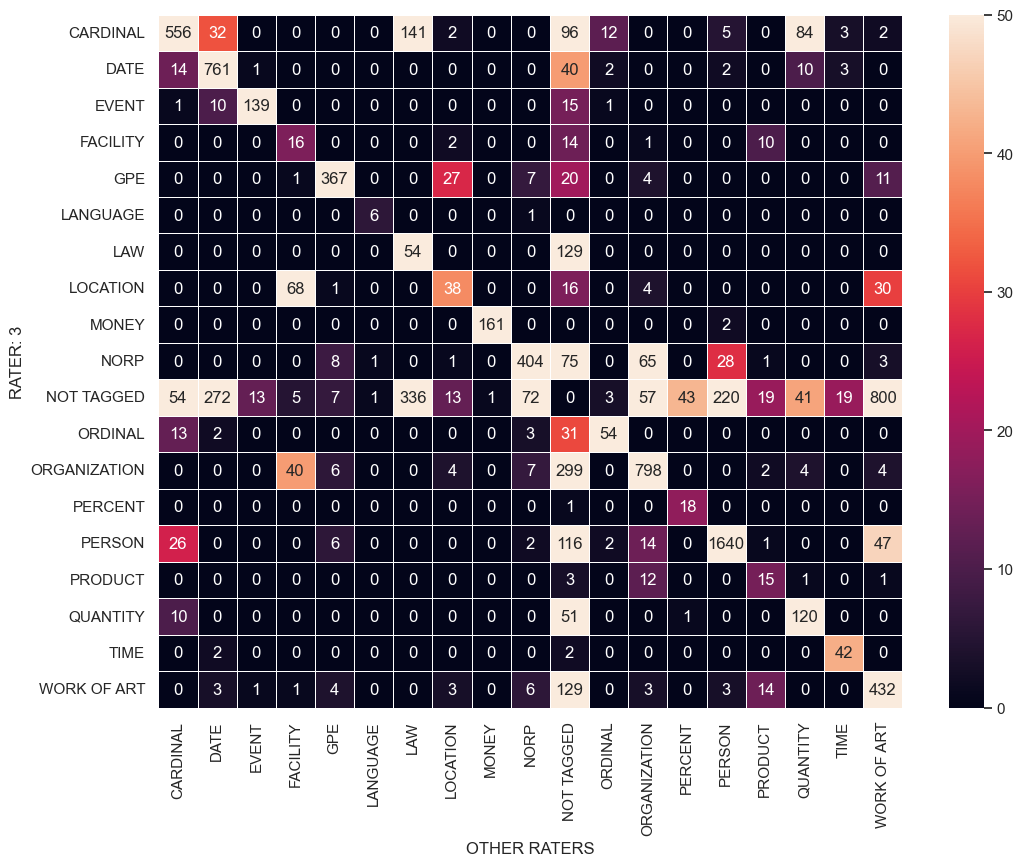

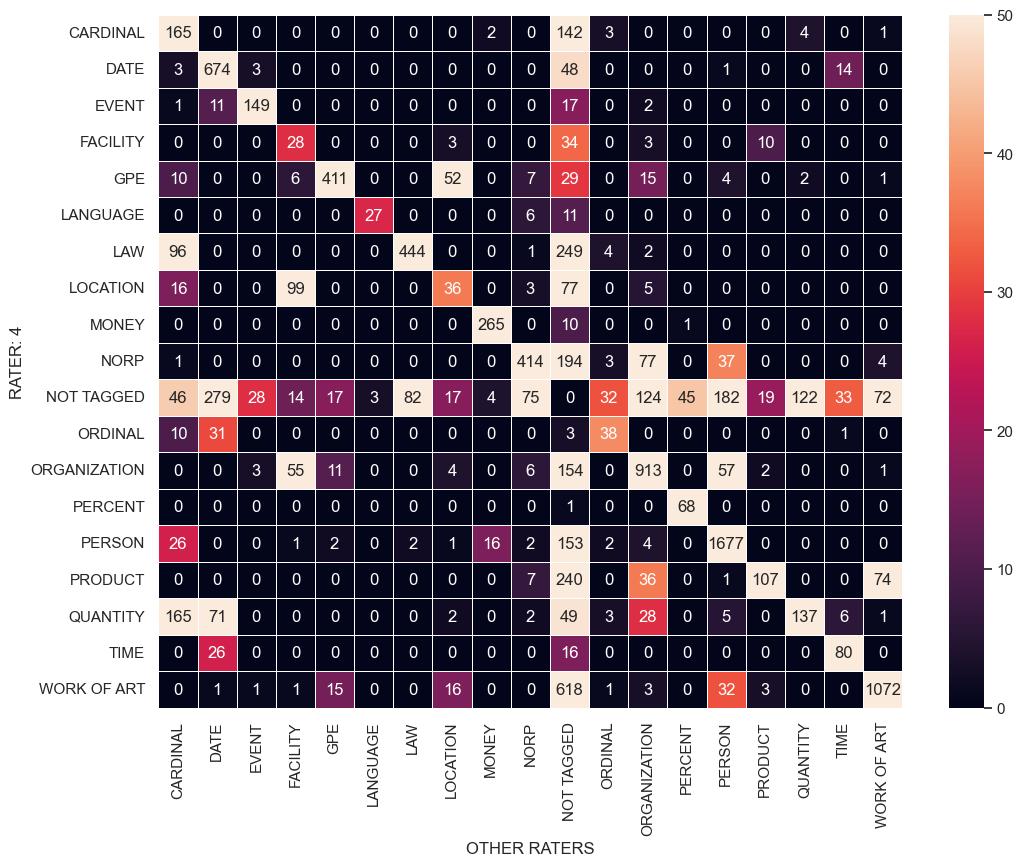

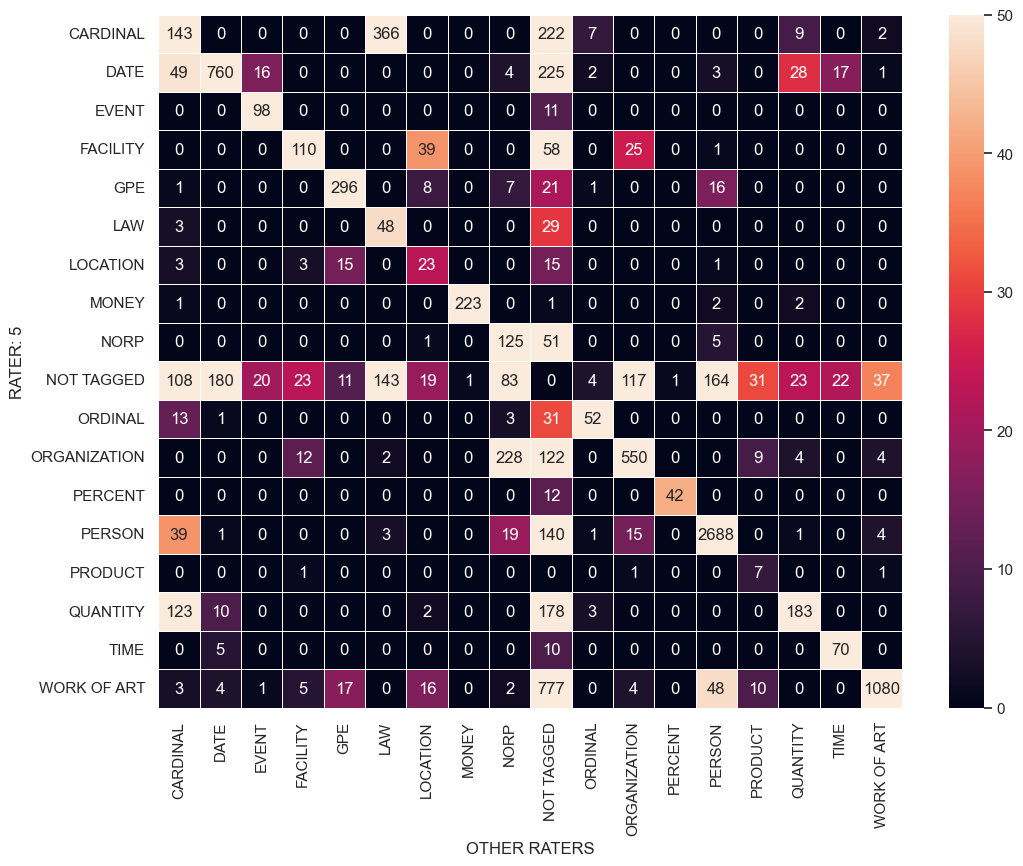

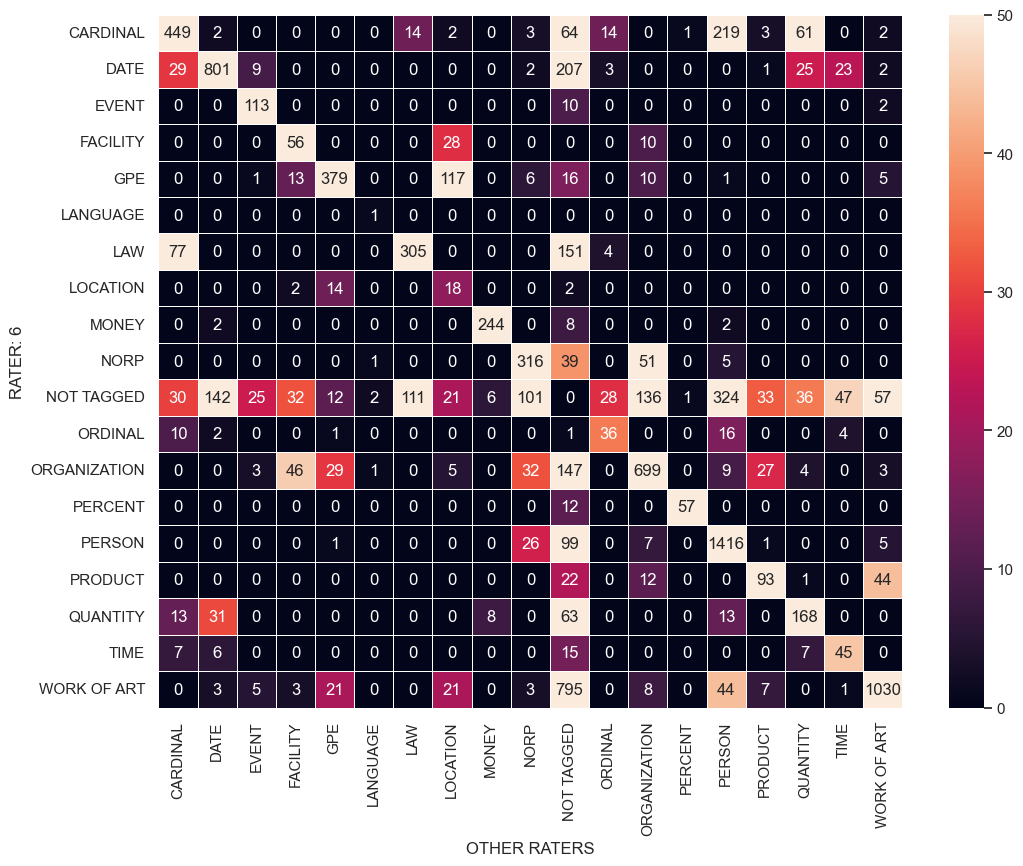

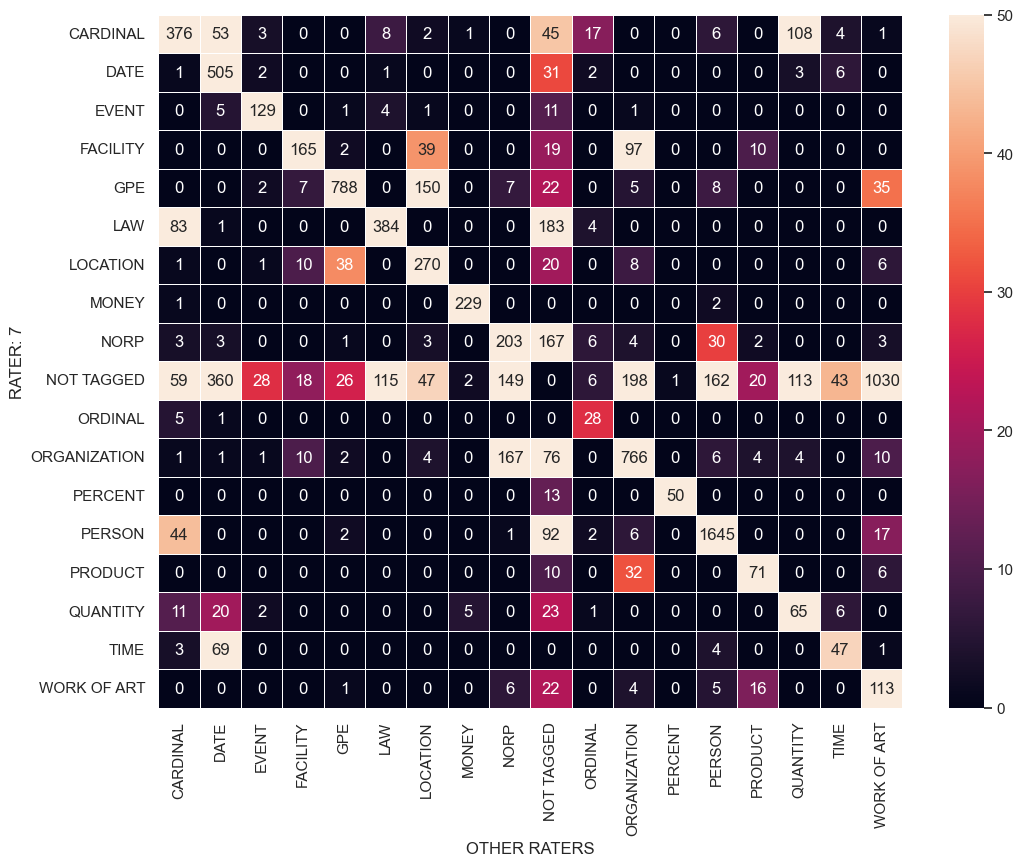

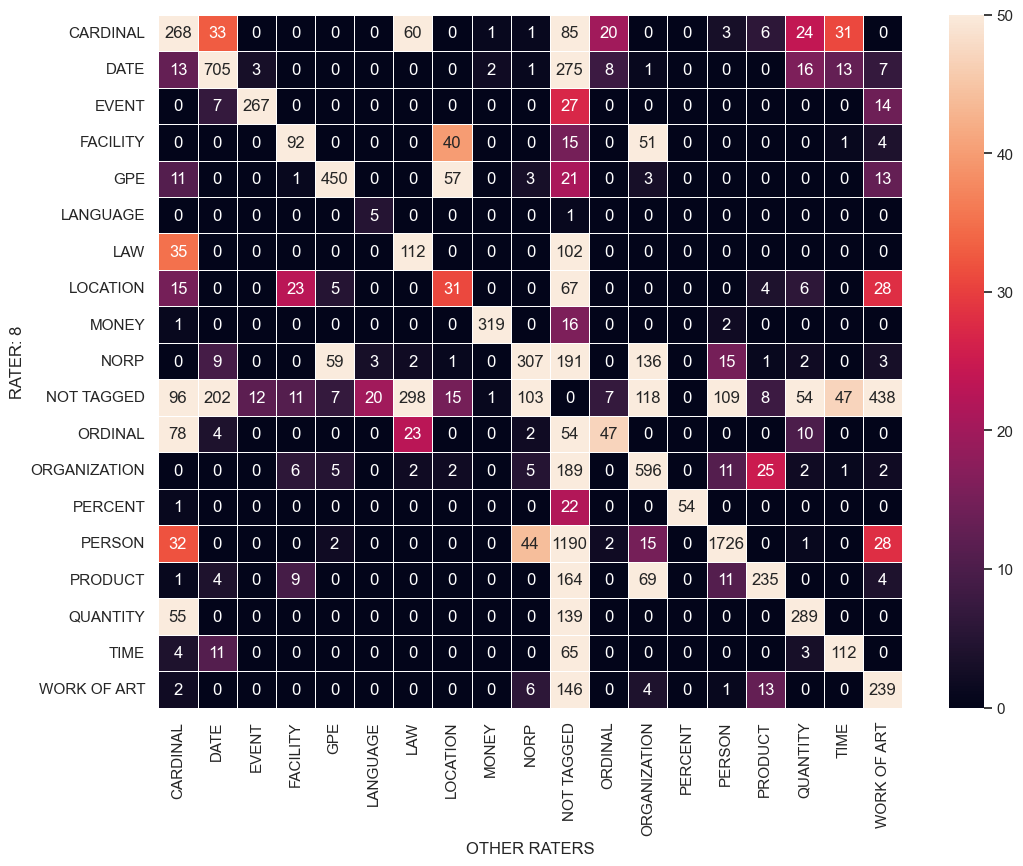

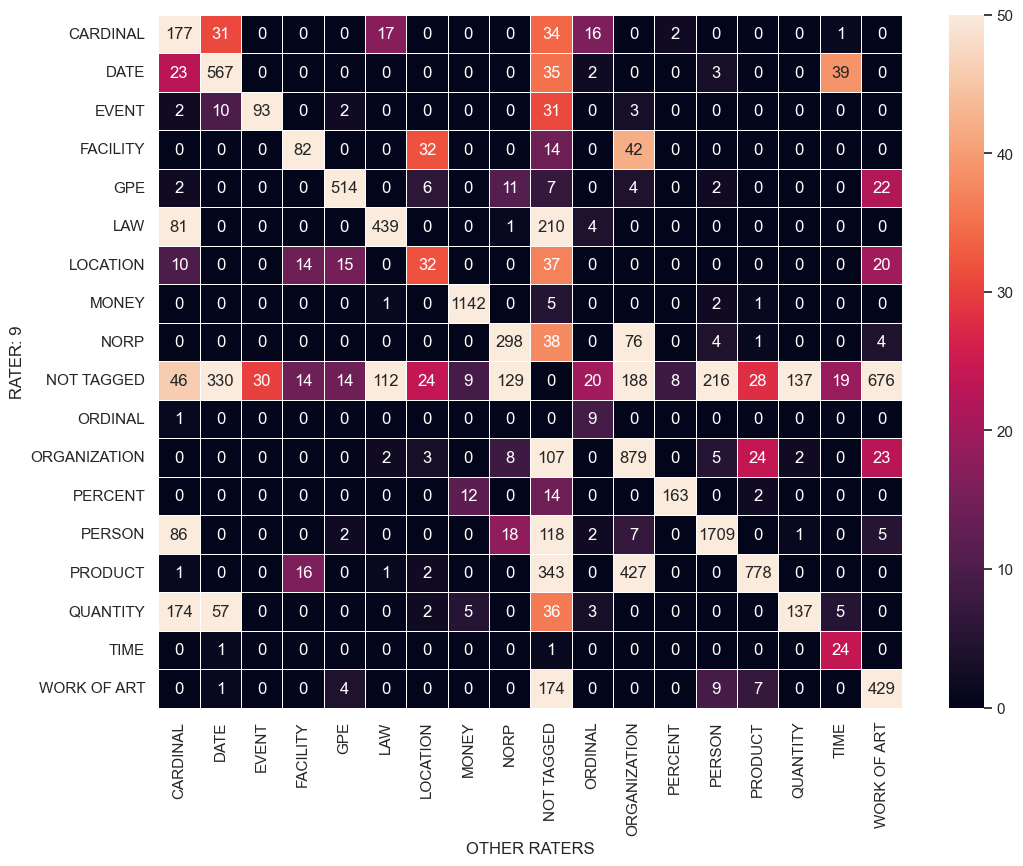

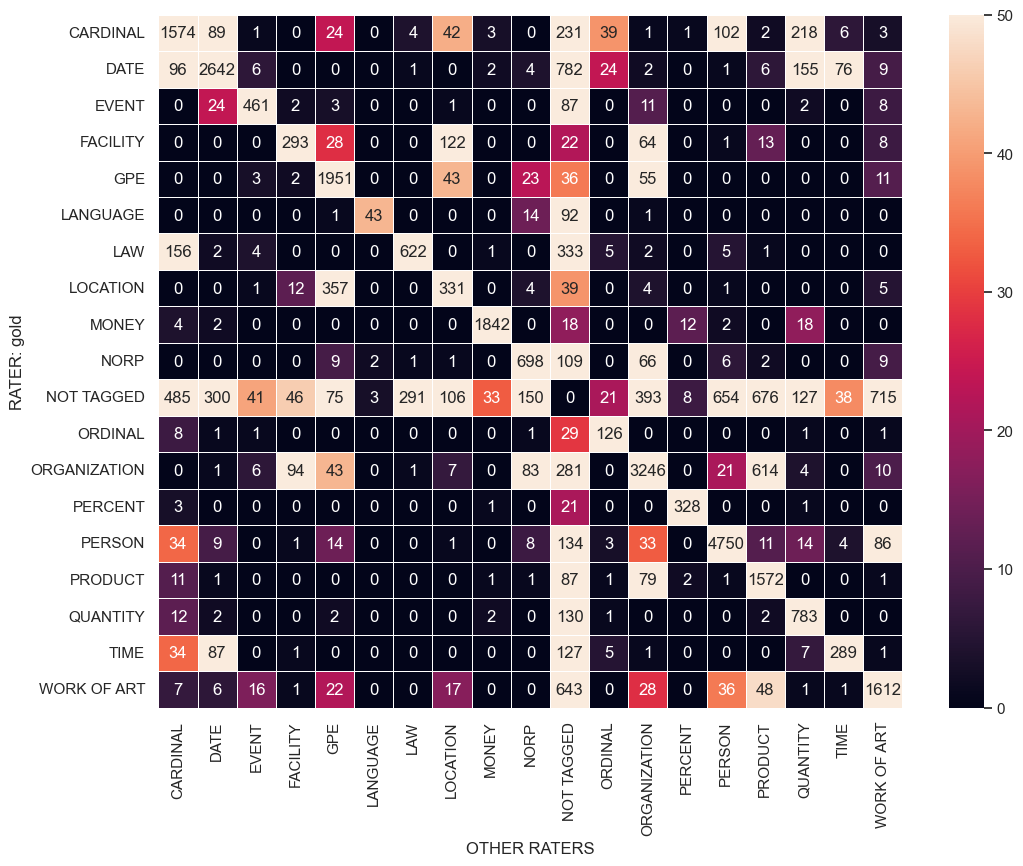

In [223]:
# Make confusion matrix for each rater vs all other raters
sns.set_theme(style='white')
for raterA in range(0, len(raters)):

    # Get the data for raterA
    raterA_data = NERdf_list[raterA].copy()
    # Get the labels for raterA
    labels = sorted(list(set(raterA_data.fillna("NOT TAGGED", inplace=False)["spans_label"].tolist())))

    # List of confusion matrices
    cms = []

    # Get list of other raters, without raterA
    other_raters = list(range(0, len(raters)))
    other_raters.remove(raterA)
    
    # Prepare data for raterB and pair
    for raterB in other_raters:
        raterB_data = NERdf_list[raterB].copy()

        # Merge data
        pair = pd.merge(raterA_data, raterB_data, on=["doc", "tokens_text"], suffixes=["_raterA", "_raterB"])
        # Drop rows where both have NAs
        pair = pair.dropna(subset=["spans_label_raterA", "spans_label_raterB"], how="all")
        # Fill np.nan with NA
        pair["spans_label_raterA"] = pair["spans_label_raterA"].fillna("NOT TAGGED")
        pair["spans_label_raterB"] = pair["spans_label_raterB"].fillna("NOT TAGGED")

        # Create confusion matrix
        # raterA = row(y), raterB = columns(x)
        cm = confusion_matrix(y_true=pair.spans_label_raterA, y_pred=pair.spans_label_raterB, labels=labels)
        cms.append(cm)

    # Make the sum across all cms
    sum_cms = sum(cms)

    # Make plot
    plt.figure(figsize=(12,9))
    with sns.axes_style("white"):
        s = sns.heatmap(sum_cms, yticklabels=labels, xticklabels=labels, annot=True, linewidths=.5, vmax=50, cbar=True, fmt="g")
        s.set(ylabel=f'RATER: {NERdf_list[raterA]["rater_id"][0]}', xlabel='OTHER RATERS')